In [5]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
import os

# ANN - FC
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import clip_grad_norm_
import os

In [6]:
import sys
sys.path.append('../Utilities')
import utils
import udfs

Loading preprocessed Data

In [2]:
DATA_DIR = "../Data/train_test_data/"

# Load datasets from Parquet files
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(DATA_DIR, "val.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
# Replace invalid characters in column names
train_df.columns = [col.replace('<', '').replace('[', '').replace(']', '').replace(',', '') for col in train_df.columns]
val_df.columns = [col.replace('<', '').replace('[', '').replace(']', '').replace(',', '') for col in val_df.columns]
test_df.columns = [col.replace('<', '').replace('[', '').replace(']', '').replace(',', '') for col in test_df.columns]

# Separate features and targets
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_val = val_df.drop('target', axis=1)
y_val = val_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

Feature Spliting for further represetation learning

In [10]:
# Fetch the survey feature names in final preprocessed data set
survey_list = ['AUDIT', 'c5_Disturbance', 'c3_Duration', 'c2_Latency', 'c7_Daytime_dysfunction', 'c6_Use_Medicatin', 'c1_Sleep_Quality', 'betel', 'coffee', 'smoke', 'insurance', 'eco_self', 'care_self', 'HF', 'fam_self', 'RAND36_SF', 'RAND36_PF', 'RAND36_EWB', 'RAND36_BP', 'RAND36_EF', 'RAND36_GH', 'RAND36_RP', 'RAND36_RE']
prefixes = ["t1_"]
final_survey_features = utils.add_prefix(survey_list, prefixes)

# Find out all survey feature names with the one-hot encoding features
X_train_columns = X_train.columns.tolist()
expanded_features = {feature: [] for feature in final_survey_features}
for col in X_train_columns:
    for feature in final_survey_features:
        if feature in col:
            expanded_features[feature].append(col)

all_survey_feature_names = []
for cols in expanded_features.values():
    all_survey_feature_names.extend(cols)

print("all_survey_feature_names:", all_survey_feature_names)

all_survey_feature_names: ['t1_AUDIT_0.0', 't1_AUDIT_1.0', 't1_AUDIT_2.0', 't1_AUDIT_3.0', 't1_c5_Disturbance_0.0', 't1_c5_Disturbance_1.0', 't1_c5_Disturbance_2.0', 't1_c5_Disturbance_3.0', 't1_c3_Duration_0.0', 't1_c3_Duration_1.0', 't1_c3_Duration_2.0', 't1_c3_Duration_3.0', 't1_c2_Latency_0.0', 't1_c2_Latency_1.0', 't1_c2_Latency_2.0', 't1_c2_Latency_3.0', 't1_c7_Daytime_dysfunction_0.0', 't1_c7_Daytime_dysfunction_1.0', 't1_c7_Daytime_dysfunction_2.0', 't1_c7_Daytime_dysfunction_3.0', 't1_c6_Use_Medicatin_0.0', 't1_c6_Use_Medicatin_1.0', 't1_c6_Use_Medicatin_2.0', 't1_c6_Use_Medicatin_3.0', 't1_c1_Sleep_Quality_0.0', 't1_c1_Sleep_Quality_1.0', 't1_c1_Sleep_Quality_2.0', 't1_c1_Sleep_Quality_3.0', 't1_betel_0', 't1_betel_1', 't1_betel_NA>', 't1_coffee_0', 't1_coffee_1', 't1_coffee_NA>', 't1_smoke_0', 't1_smoke_1', 't1_smoke_NA>', 't1_insurance_0.0', 't1_insurance_1.0', 't1_eco_self_0.0', 't1_eco_self_1.0', 't1_care_self_0.0', 't1_care_self_1.0', 't1_HF_0.0', 't1_HF_1.0', 't1_fam_se

In [12]:
# All other features names
other_feature_names = [col for col in X_train_columns if col not in all_survey_feature_names]

print("Other_feature_names:", other_feature_names)

Other_feature_names: ['t1_age', 't1_waist_y', 't1_Glucose_AC_y', 't1_Triglyceride_y', 't1_HDL_C_y', 't1_AST_GOT', 't1_ALT_GPT', 't1_gamgt', 't1_Insulin', 't1_T_Cholesterol', 't1_LDL_C_direct', 't1_VLDL_C', 't1_Non_HDL_C', 't1_T_CHOL_HDL_C', 't1_LDL_C_HDL_C', 't1_HS_CRP', 't1_Hb_A1c', 't1_Uric_Acid', 't1_HOMA_IR', 't1_Adiponectin', 't1_Leptin', 't1_TotalVitaminD', 't1_BMI', 't1_hyper', 't1_fg', 't1_HDL', 't1_trig', 't1_sarcf', 't1_ms2', 't1_HBV_', 't1_HCV_', 't1_HBsAg_x_num', 't1_Anti_HCV_x_num', 't1_year_come', 't1_sex_0', 't1_sex_1', 't1_w_0', 't1_w_1', 't1_DM_determine_0', 't1_DM_determine_1', 't1_CKD_-1', 't1_CKD_1', 't1_CKD_2', 't1_CKD_3']


Tesor Dataset Preparation

In [17]:
# Split features
X1_train = X_train[all_survey_feature_names]
X2_train = X_train[other_feature_names]
X1_val = X_val[all_survey_feature_names]
X2_val = X_val[other_feature_names]


# transfer to torch tensor
X1_train_tensor = torch.tensor(X1_train.values, dtype=torch.float32)
X2_train_tensor = torch.tensor(X2_train.values, dtype=torch.float32)
X1_val_tensor = torch.tensor(X1_val.values, dtype=torch.float32)
X2_val_tensor = torch.tensor(X2_val.values, dtype=torch.float32)

In [18]:
# Add Gaussian noise for X2 data
noise_std = 0.1  

noise_train = torch.randn_like(X2_train_tensor) * noise_std
X2_train_noisy = X2_train_tensor + noise_train
noise_val = torch.randn_like(X2_val_tensor) * noise_std
X2_val_noisy = X2_val_tensor + noise_val

In [21]:
# Survey features shape
X1_train_tensor.shape

torch.Size([2820, 86])

In [22]:
# Non-survey feaures shape
X2_train_tensor.shape

torch.Size([2820, 44])

Proposed Model applying contrastive learning with Guassian Noise

In [19]:
# Encoders for generating Pos and Neg samples
# Add Regularizer
class Encoder1(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(Encoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64)
        )

    def forward(self, x):
        return self.encoder(x)

class Encoder2(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(Encoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64)
        )

    def forward(self, x):
        return self.encoder(x)

In [20]:
def info_nce_loss(features1, features2, temperature=0.1):
  # feature normalization
  features1 = F.normalize(features1, dim=1)
  features2 = F.normalize(features2, dim=1)

  # compute similarity matrix
  similarity_matrix = torch.matmul(features1, features2.T)

  # select positives and negatives
  mask = torch.eye(similarity_matrix.shape[0], dtype=torch.bool)
  positives = similarity_matrix[mask].view(similarity_matrix.shape[0], -1)
  negatives = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

  logits = torch.cat([positives, negatives], dim=1)
  labels = torch.zeros(logits.shape[0], dtype=torch.long)

  logits = logits / temperature
  return logits, labels

In [23]:
batch_size = 64
num_workers = 2

# create data loader
train_loader = DataLoader(TensorDataset(X1_train_tensor, X2_train_noisy), batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(TensorDataset(X1_val_tensor, X2_val_noisy), batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [24]:
for X1_batch, X2_batch in train_loader:
  # print(X1_batch, X2_batch)
  print(X1_batch.shape)
  print(X2_batch.shape)
  break

torch.Size([64, 86])
torch.Size([64, 44])


In [25]:
# Model init
X1_input_dim = X1_batch.shape[1]
X2_input_dim = X2_batch.shape[1]
print("X1_input_dim: ", X1_input_dim, "X2_input_dim: ", X2_input_dim)

wd = 1e-3
lr = 0.001

#define model
encoder1 = Encoder1(input_dim=X1_input_dim)
encoder2 = Encoder2(input_dim=X2_input_dim)

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(encoder1.parameters(), lr=lr, weight_decay=wd)
optimizer2 = torch.optim.Adam(encoder2.parameters(), lr=lr, weight_decay=wd)

def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

X1_input_dim:  86 X2_input_dim:  44


In [26]:
encoder1.apply(init_weights)
encoder2.apply(init_weights)
num_epochs = 100

In [27]:
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    train_loss_sum, train_total = 0, 0
    encoder1.train()
    encoder2.train()
    for X1, X2 in train_loader:
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        out1 = encoder1(X1)
        out2 = encoder2(X2)
        #loss fuction
        logits, labels = info_nce_loss(out1, out2)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        train_loss_sum += loss.item() * X1.size(0)
        train_total += X1.size(0)
    avg_train_loss = train_loss_sum / train_total
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average training Loss: {avg_train_loss:.4f}')

    #add patience mechanism
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    early_stopping_triggered = False

    encoder1.eval()
    encoder2.eval()
    with torch.no_grad():
        val_loss_sum, val_total = 0, 0
        for X1, X2 in val_loader:
            out1 = encoder1(X1)
            out2 = encoder2(X2)
            #loss fuction
            logits, labels = info_nce_loss(out1, out2)
            loss = criterion(logits, labels)
            val_loss_sum += loss.item() * X1.size(0)
            val_total += X1.size(0)
        # cal avg loss
        avg_val_loss = val_loss_sum / val_total
        val_losses.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          patience_counter = 0  # reset counter
          # save models
          torch.save(encoder1.state_dict(), 'best_encoder1.pth')
          torch.save(encoder2.state_dict(), 'best_encoder2.pth')
        else:
          patience_counter += 1

        # check early stopping
        if patience_counter >= patience:
          early_stopping_triggered = True
          print("Early stopping triggered")
          break

Epoch [1/100], Average training Loss: 4.8350
Epoch [1/100], Average validation Loss: 4.4288
Epoch [2/100], Average training Loss: 4.6468
Epoch [2/100], Average validation Loss: 4.2826
Epoch [3/100], Average training Loss: 4.4779
Epoch [3/100], Average validation Loss: 4.2137
Epoch [4/100], Average training Loss: 4.3745
Epoch [4/100], Average validation Loss: 4.0679
Epoch [5/100], Average training Loss: 4.2961
Epoch [5/100], Average validation Loss: 3.9457
Epoch [6/100], Average training Loss: 4.1953
Epoch [6/100], Average validation Loss: 3.9167
Epoch [7/100], Average training Loss: 4.1198
Epoch [7/100], Average validation Loss: 3.8581
Epoch [8/100], Average training Loss: 4.0746
Epoch [8/100], Average validation Loss: 3.8040
Epoch [9/100], Average training Loss: 4.0342
Epoch [9/100], Average validation Loss: 3.7509
Epoch [10/100], Average training Loss: 3.9520
Epoch [10/100], Average validation Loss: 3.7359
Epoch [11/100], Average training Loss: 3.9066
Epoch [11/100], Average validati

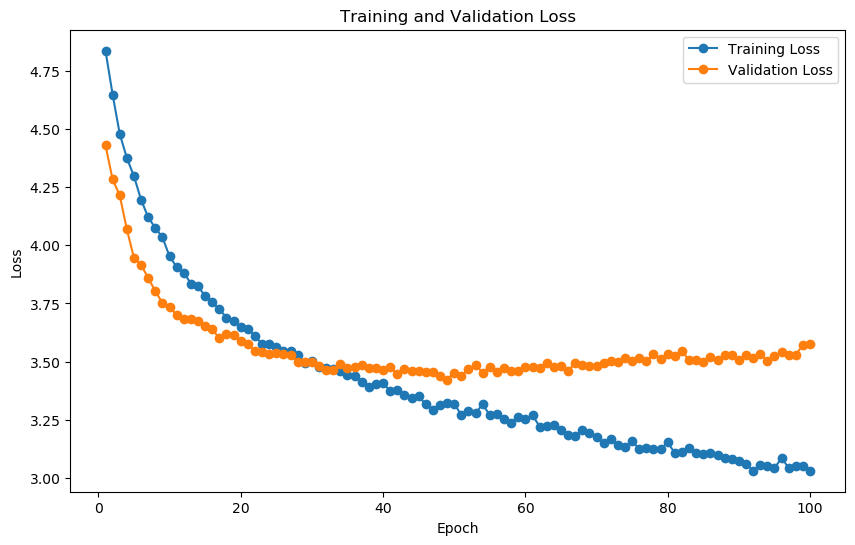

In [28]:
# Plot
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Downstream Task Implementation and Comparison

In [29]:
def calculate_auc(y_true, y_prob):
  n_classes = len(np.unique(y_true))
  y_ture_binarized = label_binarize(y_true.values, classes=np.arange(n_classes))

  auc_scores = roc_auc_score(y_ture_binarized, y_prob, multi_class='ovr', average=None)
  for i, auc_score in enumerate(auc_scores):
    print(f"Class {i} AUC: {auc_score:.4f}")
  overall_auc_macro = roc_auc_score(y_ture_binarized, y_prob, multi_class='ovr', average='macro')
  print(f"Overall AUC (Macro-average): {overall_auc_macro:.4f}")
  return

In [33]:
# Train for all features with embedding in Test set
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# Logistic Regression
X1_test_tensor = torch.FloatTensor(X_test[all_survey_feature_names].values)
with torch.no_grad():
    # encoded_X_train = encoder1(X1_train_tensor)
    encoded_X_test = encoder1(X1_test_tensor)
encoded_X_test_np = encoded_X_test.numpy()
y_test_np = y_test.values

# Train for all features with embedding
X_test_others_np = X_test[other_feature_names]
combined_features = np.concatenate([encoded_X_test_np, X_test_others_np], axis=1)
# lr = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
# lr.fit(combined_features, y_test_np)
gnb = GaussianNB(var_smoothing=1e-9)
gnb.fit(combined_features, y_test_np)

test_accuracy = gnb.score(combined_features, y_test_np)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_test_proba = gnb.predict_proba(combined_features)
calculate_auc(y_test, y_test_proba)

Test Accuracy: 32.88%
Class 0 AUC: 0.7213
Class 1 AUC: 0.9314
Class 2 AUC: 0.6971
Class 3 AUC: 0.9325
Class 4 AUC: 0.9994
Overall AUC (Macro-average): 0.8563


In [36]:
# Comparision
# Run regression for all data without embedding by contrastive learning with guassian noise
gnb_c = GaussianNB(var_smoothing=1e-9)
gnb_c.fit(X_train, y_train)
print(f"Test Accuracy: {gnb_c.score(X_test, y_test) * 100:.2f}%")

y_test_proba = gnb_c.predict_proba(X_test)
calculate_auc(y_test, y_test_proba)

Test Accuracy: 9.30%
Class 0 AUC: 0.4970
Class 1 AUC: 0.5949
Class 2 AUC: 0.5779
Class 3 AUC: 0.6570
Class 4 AUC: 0.5675
Overall AUC (Macro-average): 0.5789
